# Nuages de mots

## Imports et stopwords

In [211]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



In [212]:
# Téléchargement des ressources NLTK si nécessaire
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [213]:
data_path = "../../data/txt_tp4"
output_dir = "../../data/results/"
os.makedirs(output_dir, exist_ok=True)

In [214]:
# stopwords français
sw = set(stopwords.words('french'))

In [233]:
stopwords = {
    # Bruit journalistique (étendu)
    "bruxelles", "soir", "matin", "hier", "demain", "samedi", "dimanche", "lundi", "mardi",
    "mercredi", "jeudi", "vendredi", "rossel", "belga", "afp", "tél", "adresse", "programme",
    "heures", "van", "etc", "cette", "tout", "deux", "comme", "sans", "bien", "tous", "grand",
    "fait", "après", "dont", "être", "très", "non", "aussi", "ans", "sous", "france", "encore",
    "monde", "faire", "cours", "trois", "autres", "entre", "avant", "cela", "alors", "même",
    "depuis", "peu", "fois", "jours", "ainsi", "dire", "autre", "année", "peut", "part", "libre",
    "toute", "moins", "avenue", "chez", "bon", "œuvre", "français", "vers", "petit", "quelques",
    "jusqu", "nouveau", "avoir", "service", "bonne", "lieu", "deuxième", "toutes", "jeunes",

    # Bruit culturel/événementiel
    "musique", "paris", "orchestre", "théâtre", "cinéma", "film", "concert", "halloween", "costume",
    "fête", "carnaval", "bd", "dessins", "animés", "série", "feuilleton", "fiction", "personnage",
    "spectacle", "exposition", "galerie", "musée", "opéra", "ballet", "danse", "scène", "artiste",

    # Bruit géographique
    "ville", "place", "rue", "quartier", "boulevard", "carrefour", "gare", "métro", "transport",
    "voiture", "bus", "train", "station", "parking", "bâtiment", "immeuble", "local", "espace",

    # Bruit politique/économique
    "pays", "gouvernement", "ministre", "élection", "parti", "loi", "décision", "réunion",
    "conférence", "sommet", "accord", "négociation", "budget", "finance", "banque", "entreprise",
    "marché", "économie", "chiffre", "statistique", "donnée", "étude", "rapport", "analyse",

    # Mots trop génériques
    "temps", "vie", "homme", "personne", "groupe", "cas", "chose", "problème", "question",
    "moment", "manière", "façon", "type", "sort", "genre", "espèce", "niveau", "domaine", "secteur",

    # Artefacts OCR
    "ena", "hmu", "xii", "xix", "xxe", "xxx", "ooo", "ii", "iii", "iv", "vi", "vii", "viii", "ix",
    "xi", "xiii", "xiv", "xv", "xvi", "xvii", "xviii", "xx", "xxi", "adm", "gar", "relâche",

    # Prénoms fréquents
    "jean", "pierre", "marie", "jacques", "michel", "luc", "paul", "henri", "louis", "philippe",
    "andre", "bernard", "robert", "claude", "daniel", "patrick", "thierry", "olivier", "nicolas",
    "christian", "didier", "françois", "serge", "alain", "marc", "yves", "gerard", "rene"
}

# --- MOTS-CIBLES À CONSERVER (PRIORITAIRE) ---
mots_cibles = {
    # Sorcellerie (étendu)
    "sorcière", "sorcières", "sorcellerie", "sorcier", "sorciers", "magie", "magique", "envoûtement",
    "envoûteuse", "envoûteur", "sortilège", "maléfice", "pouvoir", "occultes", "occulte", "sabbat",
    "grimoire", "rituel", "incantation", "potion", "chaudron", "balai", "familier", "démon",
    "diable", "satan", "lucifer", "exorcisme", "possédé", "possédée", "vaudou", "chaman",
    "chamanisme", "druide", "alchimie", "astrologie", "nécromancie", "spiritisme", "esprit",

    # Féminisme (étendu)
    "féminin", "féminité", "féminisme", "féministes", "mlf", "sororité", "émancipation", "libération",
    "autonomie", "réappropriation", "symbole", "matriarcat", "déesse", "triple déesse", "witch",
    "witchcraft", "feminist", "feminism", "women", "woman", "sisterhood", "empowerment",

    # Justice/persécution
    "procès", "tribunal", "accusation", "torture", "bûcher", "exécution", "châtiment", "inquisition",
    "condamnation", "victime", "aveu", "aveux", "chasse", "persécution", "bannissement", "ostracisme",
    "lynchage", "autodafé", "pyre", "supplice", "interdit", "censure", "répression",

    # Folklore (Wallonie/Belgique)
    "légende", "mythe", "conte", "tradition", "macrale", "tchestia", "quétaine", "nutons", "gille",
    "duvel", "krakeling", "sint", "noël", "carnaval", "masque", "démonologie", "superstition",

    # Stigmatisation
    "marginale", "rejet", "exclusion", "tabou", "hystérie", "folie", "démoniaque", "possédée",
    "maudite", "hérétique", "déviant", "bizarre", "anormal", "monstrueux", "satanique", "perverse",
    "dangereuse", "subversive", "rebelle", "indomptable", "sauvage", "hérétique"
}


### Nettoyage du texte

In [234]:
# Nettoyage du texte
def nettoyer_texte(text):
    """Nettoyage agressif avec conservation des mots-cibles."""
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)  # Conserve les accents
    text = re.sub(r'\d+', ' ', text)  # Supprime les chiffres
    text = re.sub(r'\b\w{1,2}\b', ' ', text)  # Mots de 1-2 lettres
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def filter_words(words):
    """Filtre les mots en priorisant les mots-cibles."""
    words = [w for w in words if w.isalpha() and len(w) > 2]
    # Conserve TOUJOURS les mots-cibles, même s'ils sont dans stopwords
    words = [w for w in words if w not in stopwords or w in mots_cibles]
    return words

def extract_ngrams(text, n=2):
    """Extrait les n-grammes (bigrammes par défaut)."""
    tokens = text.split()
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

def extract_year(filename):
    parts = filename.split("_")
    for part in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None

In [217]:
# --- CHARGEMENT DES DONNÉES ---
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
print(f" Nombre de fichiers : {len(files)}")

 Nombre de fichiers : 999


In [235]:
# --- ANALYSE PAR DÉCENNIE ---
corpus_decennies = {} # corpus globale
corpus_decennies = {}  # par décennie

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    dec = (year // 10) * 10
    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors='ignore') as ff:
        text = nettoyer_texte(ff.read())
    words = filter_words(text.split())
    corpus.extend(words)
    corpus_decennies.setdefault(dec, []).append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus))


Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 5738112


In [ ]:
# --- ANALYSE DES N-GRAMMES PAR DÉCENNIE ---
for dec, texts in corpus_decennies.items():
    print(f"\n Analyse des années {dec}...")

    # Combinaison de tous les textes de la décennie
    combined_text = " ".join(texts)

    # Extraction des bigrammes et trigrammes
    vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=list(stopwords))
    X = vectorizer.fit_transform([combined_text])
    feature_names = vectorizer.get_feature_names_out()
    counts = X.toarray()[0]

    # Filtrage des n-grammes pertinents
    ngram_counts = {feature_names[i]: counts[i] for i in range(len(feature_names))
                   if any(mot in feature_names[i].lower() for mot in mots_cibles)}

    if not ngram_counts:
        print(f" Aucune occurrence thématique trouvée pour les années {dec}.")
        continue


 Analyse des années 1960...

 Analyse des années 1970...

 Analyse des années 1950...


In [ ]:
top_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:50]
print(f" Top 15 n-grammes pour les années {dec}:")
for ngram, count in top_ngrams[:100]:
        print(f"  - {ngram} ({count})")

 Top 15 n-grammes pour les années 1950:
  - sorcière (535)
  - esprit (509)
  - pouvoir (290)
  - chasse (243)
  - noël (202)
  - diable (191)
  - tribunal (153)
  - faveur (145)
  - victime (144)
  - exécution (126)
  - contenant (117)
  - procès (117)
  - sauvage (107)
  - victimes (107)
  - magie (102)
  - masque (89)
  - folie (86)
  - sorcière blanche (86)
  - tradition (86)
  - gilles (82)
  - conte (79)
  - magique (78)
  - une sorcière (77)
  - sauvages (68)
  - chasseur (65)
  - diables (64)
  - contenance (62)
  - interdit (62)
  - libération (61)
  - spirituel (58)
  - légende (57)
  - pouvoirs (57)
  - dangereuse (55)
  - sorcières (53)
  - raconte (50)
  - spirituelle (49)
  - démonstration (45)
  - féminin (45)
  - interdite (45)
  - traditionnelle (45)
  - contes (44)
  - démon (44)
  - aveu (43)
  - son esprit (43)
  - contemporaine (41)
  - féminine (41)
  - chasse aux (39)
  - aveux (38)
  - esprits (38)
  - contemporains (37)


### TF-IDF sur corpus global

In [ ]:
documents = []
for f in files:
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    words = filter_words(text.split())
    documents.append(" ".join(words))

vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(documents)

# Moyenne des scores TF-IDF par mot
import numpy as np
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().mean(axis=0)))
sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 50 mots TF-IDF :", sorted_words[:50])

Top 50 mots TF-IDF : [('les', np.float64(0.5038735661499969)), ('des', np.float64(0.36635685686249747)), ('une', np.float64(0.242292022678171)), ('pour', np.float64(0.21638648259867366)), ('est', np.float64(0.1824134177611936)), ('dans', np.float64(0.18035895923779394)), ('par', np.float64(0.18010991005473062)), ('que', np.float64(0.16787113549426627)), ('qui', np.float64(0.16776447382503173)), ('avec', np.float64(0.1558801142244321)), ('sur', np.float64(0.10895801176480732)), ('pas', np.float64(0.09940758089001422)), ('mais', np.float64(0.098589816151948)), ('plus', np.float64(0.09838484823306623)), ('enf', np.float64(0.08770605802391872)), ('son', np.float64(0.08582198048694241)), ('vous', np.float64(0.07841605461587643)), ('aux', np.float64(0.0775967611951632)), ('nous', np.float64(0.063110791661097)), ('maison', np.float64(0.061892989035037815)), ('elle', np.float64(0.061673808664431534)), ('theatre', np.float64(0.05467022301564107)), ('sont', np.float64(0.05341495358255367)), ('se

### Generation nouage de mots

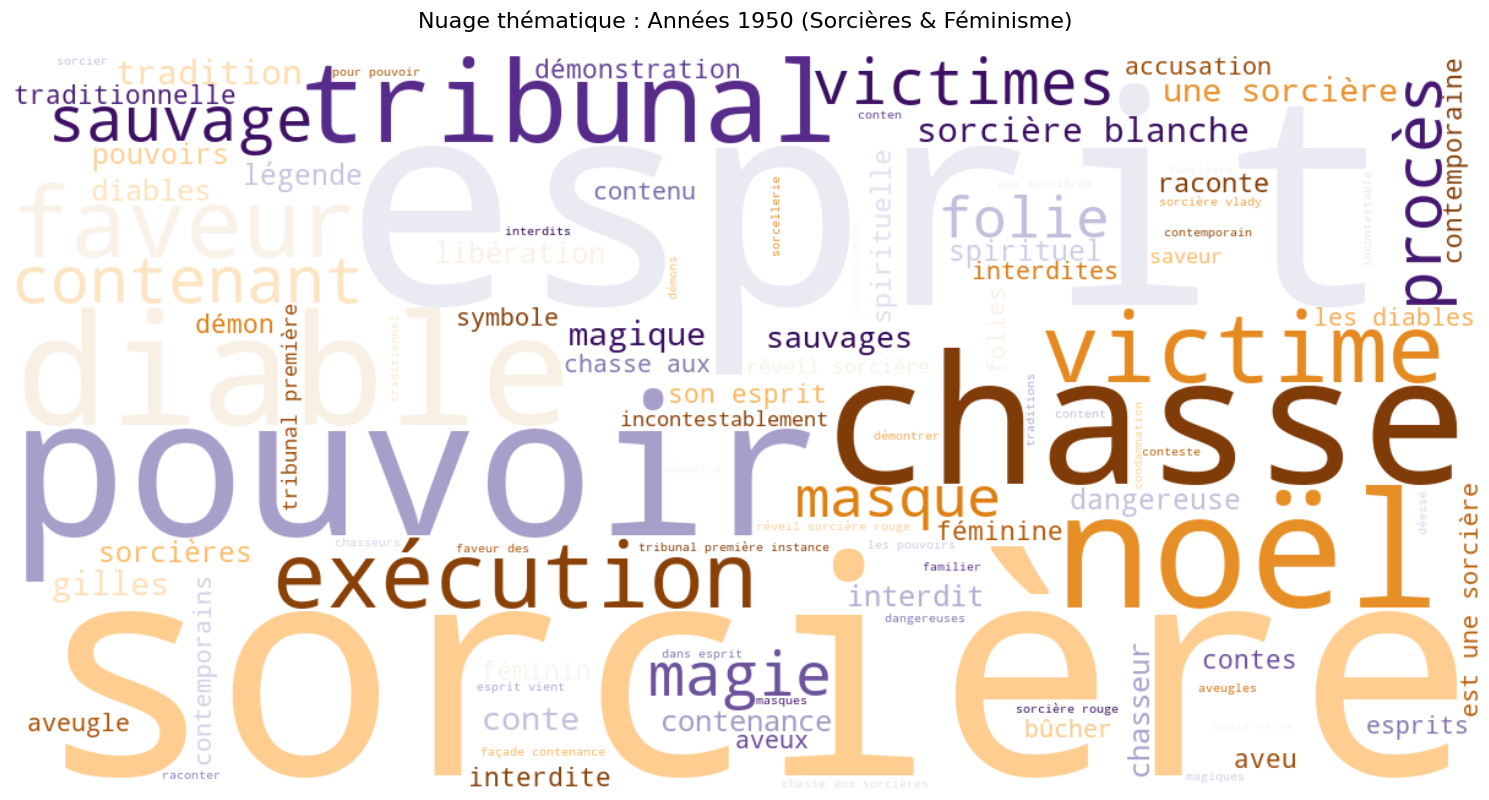

In [ ]:
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='PuOr',  # Purple-Orange (ou 'PRGn' pour Purple-Green)
    max_words=100,
    min_font_size=10,
    prefer_horizontal=0.9
).generate_from_frequencies(ngram_counts)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Nuage thématique : Années {dec} (Sorcières & Féminisme)", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig(f"{output_dir}nuage_{dec}.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Export des résultats
with open(f"{output_dir}resultats_ngrams.csv", "w", encoding="utf-8") as f:
    f.write("décennie;ngram;count\n")
    for dec, texts in corpus_decennies.items():
        combined_text = " ".join(texts)
        vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=list(stopwords))
        X = vectorizer.fit_transform([combined_text])
        feature_names = vectorizer.get_feature_names_out()
        counts = X.toarray()[0]

        for i in range(len(feature_names)):
            if any(mot in feature_names[i].lower() for mot in mots_cibles):
                f.write(f"{dec};{feature_names[i]};{counts[i]}\n")
print(f" Analyse terminée. Résultats exportés dans {output_dir}")


 Analyse terminée. Résultats exportés dans ../../data/results/


### Nuage TF-IDF

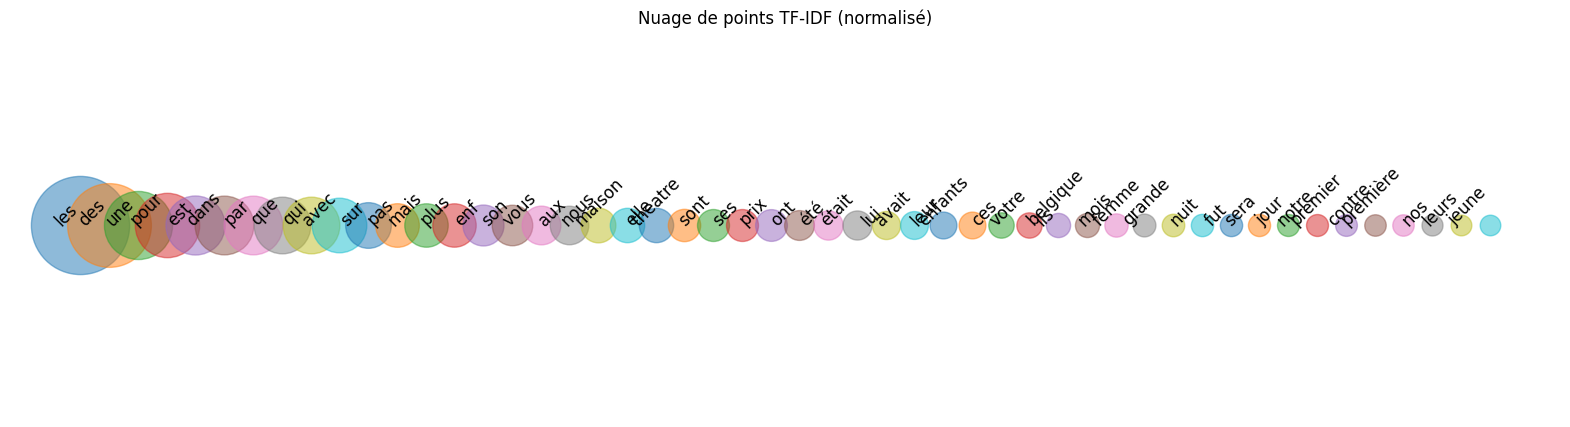

In [ ]:
plt.figure(figsize=(20,5))

# Normalisation des scores
max_score = max(score for _, score in sorted_words)

for i, (word, score) in enumerate(sorted_words):
    plt.scatter(i, 0, s=(score/max_score)*5000, alpha=0.5)  # taille normalisée
    plt.text(i, 0, word, fontsize=12, rotation=45, ha='right')

plt.axis('off')
plt.title("Nuage de points TF-IDF (normalisé)")
plt.show()


### Créer un texte global pour générer le nuage

In [ ]:
corpus = []             # Corpus global
corpus_decennies = {}   # Corpus par décennie

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    
    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    
    words = filter_words(text.split())
    
    corpus.extend(words)
    
    corpus_decennies.setdefault(dec, [])
    corpus_decennies[dec].append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus))


Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 2869056


### Nouage de mots globale

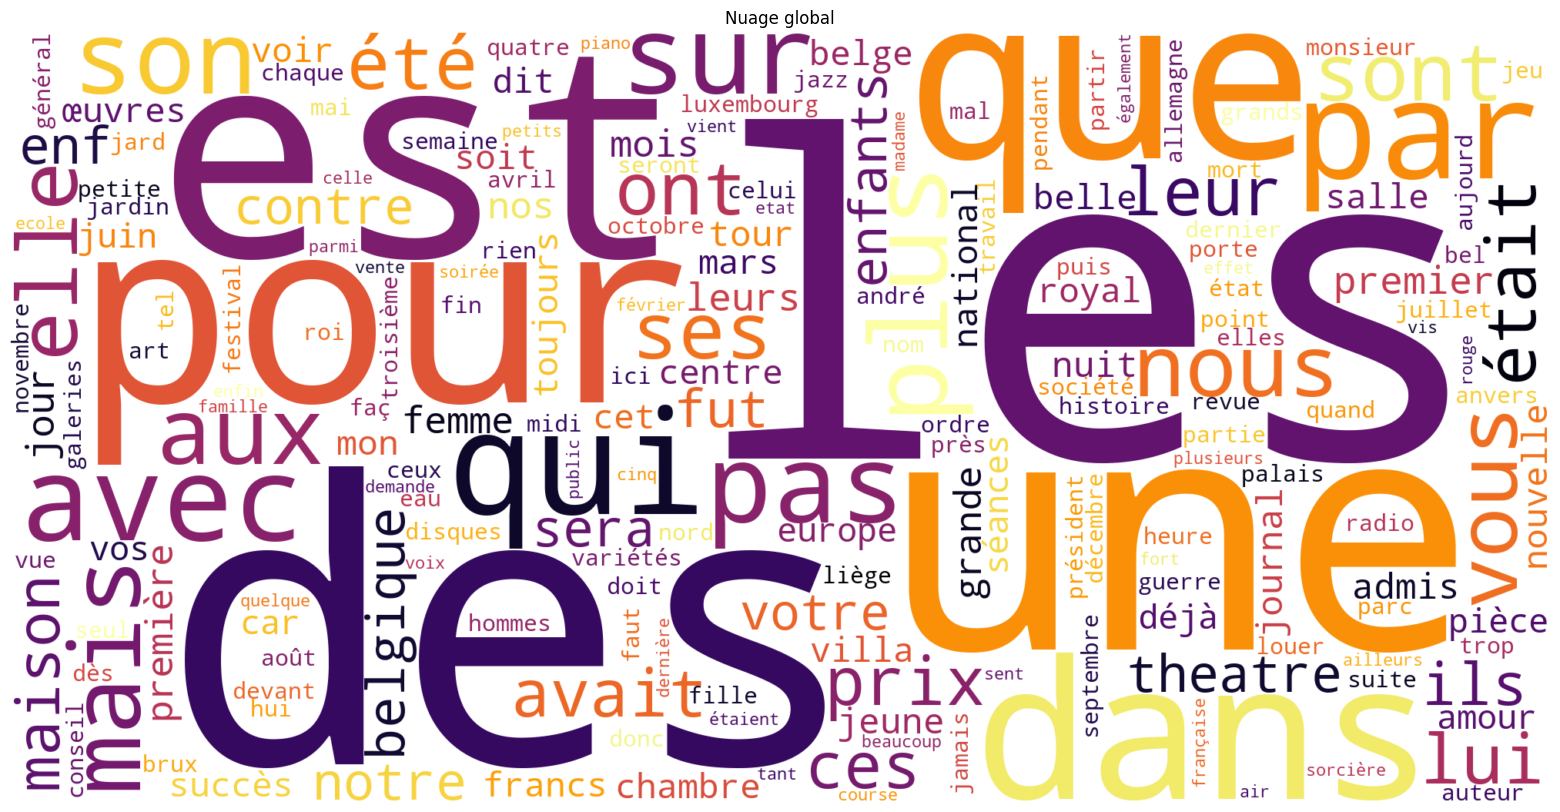

In [ ]:
frequencies = Counter(corpus)

cloud = WordCloud(
    width=2000, height=1000,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(frequencies)

plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage global")
plt.show()


### Nouages de mots par decennie

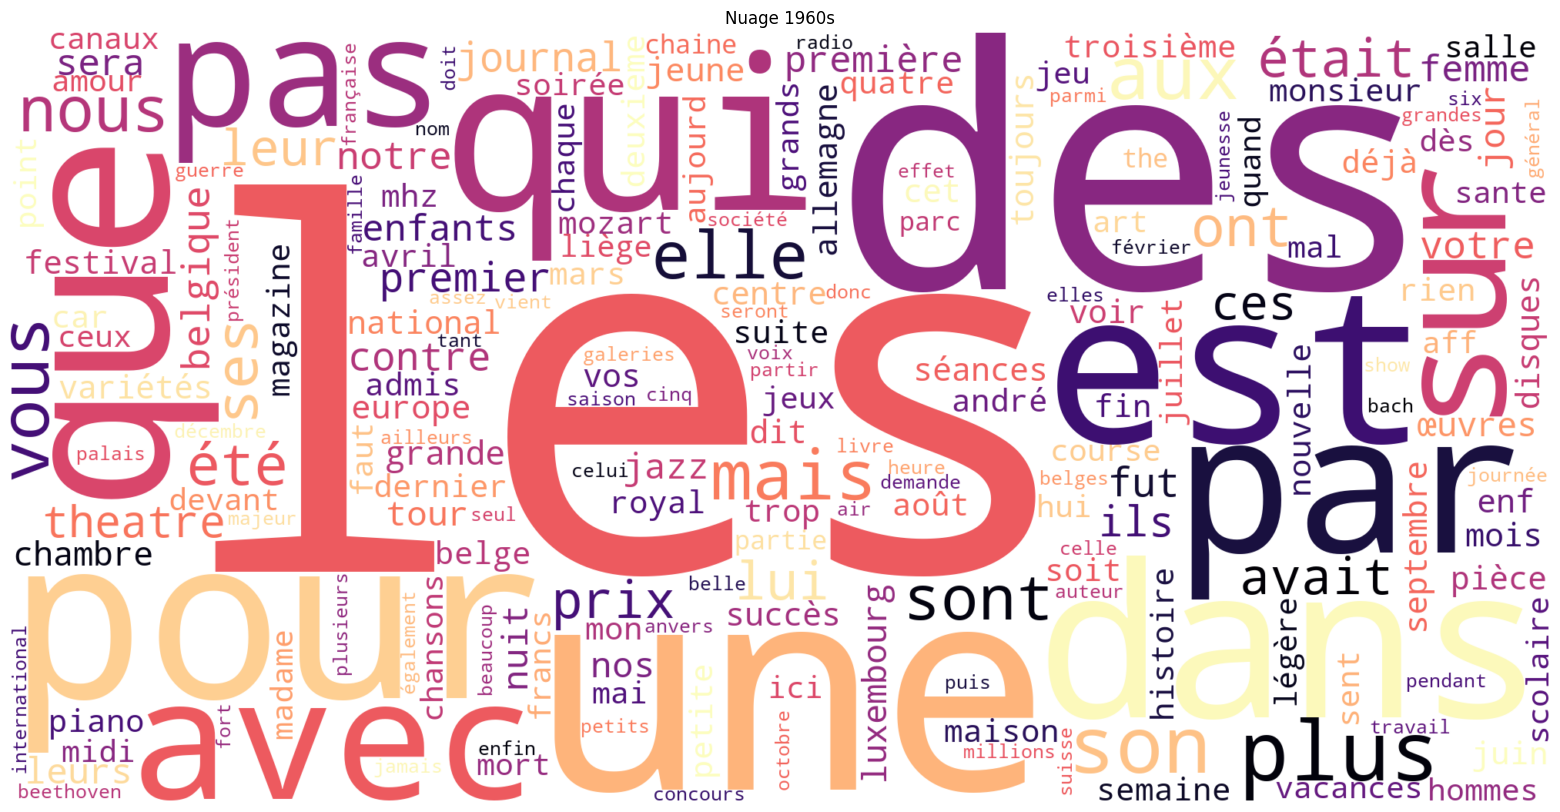

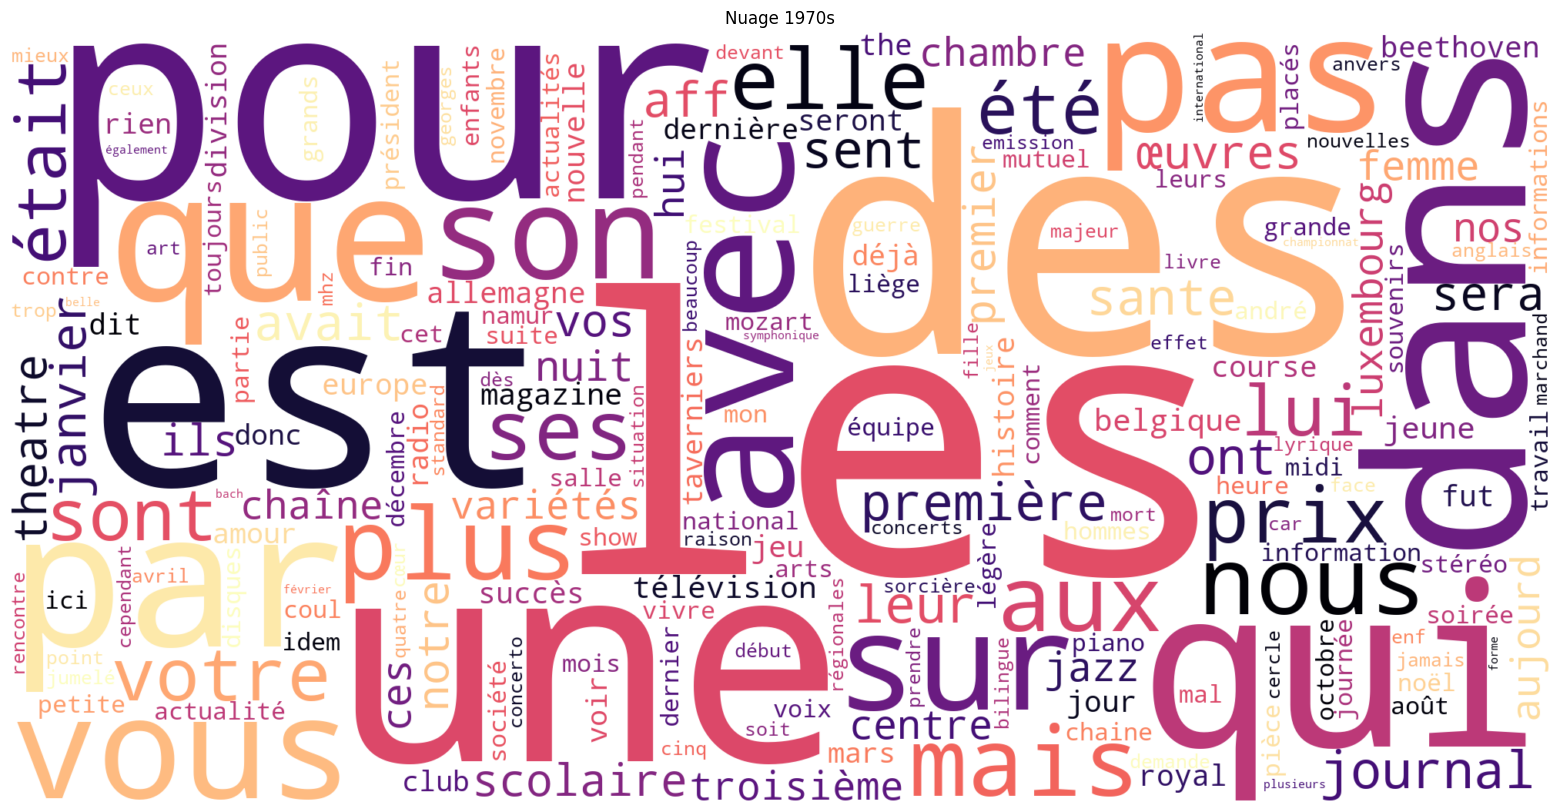

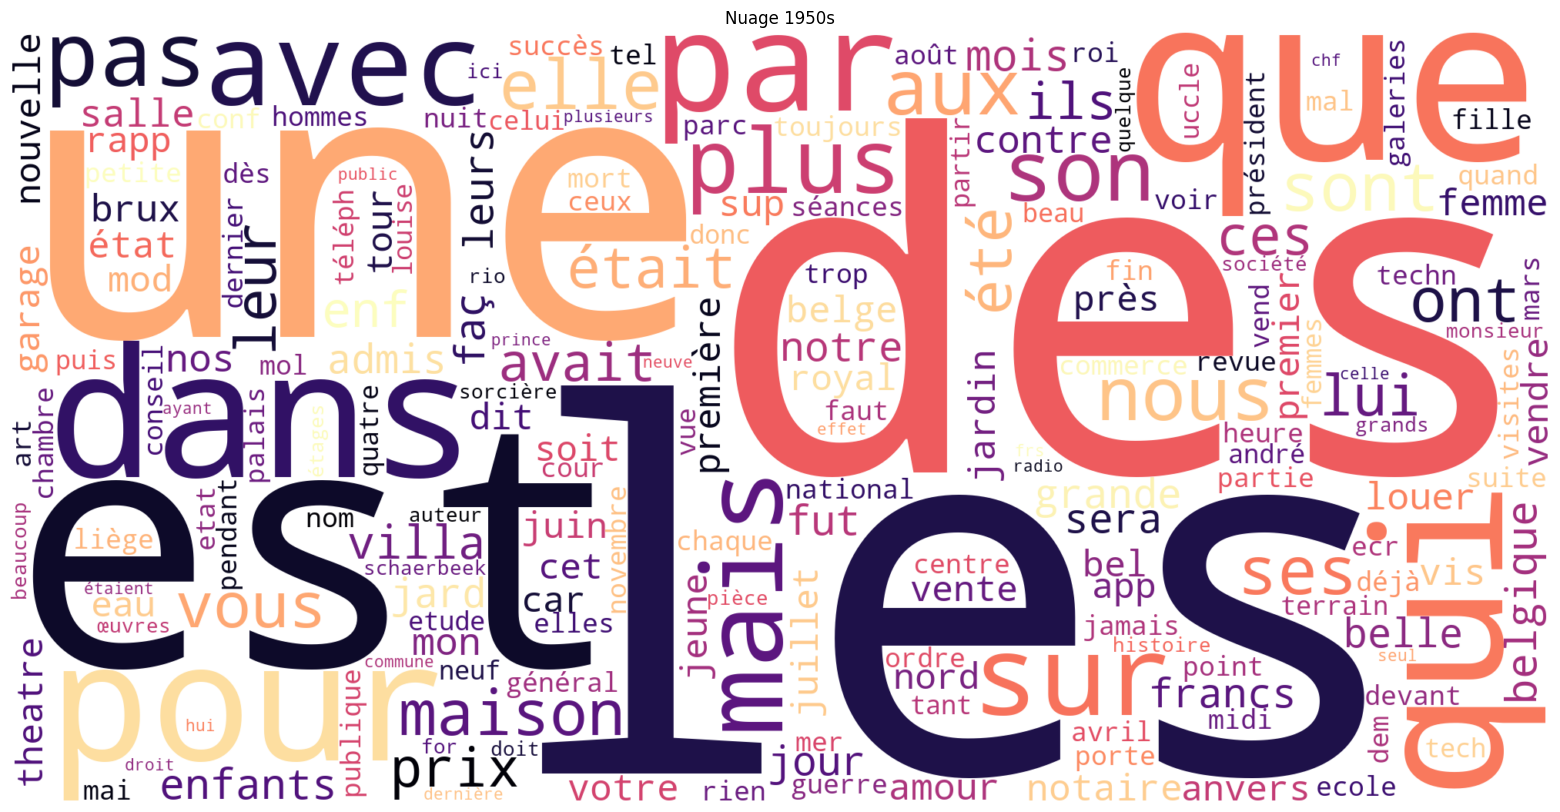

In [ ]:
for dec, textes in corpus_decennies.items():
    words_dec = filter_words(" ".join(textes).split())
    freq_dec = Counter(words_dec)
    
    cloud_dec = WordCloud(
        width=2000, height=1000,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(freq_dec)
    
    plt.figure(figsize=(20,10))
    plt.imshow(cloud_dec, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage {dec}s")
    plt.show()
